In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 设置字体大小
plt.rcParams['font.size'] = 20
# 加粗图片边框
plt.rcParams['axes.linewidth'] = 2

In [2]:
data_path = r'..\Question\Wimbledon_featured_matches.csv'
data = pd.read_csv(data_path)
print(data.head())

              match_id         player1        player2 elapsed_time  set_no  \
0  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:00:00       1   
1  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:00:38       1   
2  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:01:01       1   
3  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:01:31       1   
4  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:02:21       1   

   game_no  point_no  p1_sets  p2_sets  p1_games  ...  p2_break_pt_won  \
0        1         1        0        0         0  ...                0   
1        1         2        0        0         0  ...                0   
2        1         3        0        0         0  ...                0   
3        1         4        0        0         0  ...                0   
4        1         5        0        0         0  ...                0   

  p1_break_pt_missed p2_break_pt_missed  p1_distance_run  p2_distance_run  \
0        

In [3]:
# 按match_id分组
grouped = data.groupby('match_id')
print(grouped.size())

match_id
2023-wimbledon-1301    300
2023-wimbledon-1302    201
2023-wimbledon-1303    134
2023-wimbledon-1304    337
2023-wimbledon-1305    246
2023-wimbledon-1306    332
2023-wimbledon-1307    232
2023-wimbledon-1308    190
2023-wimbledon-1309    213
2023-wimbledon-1310    318
2023-wimbledon-1311    170
2023-wimbledon-1312    275
2023-wimbledon-1313    290
2023-wimbledon-1314    185
2023-wimbledon-1315    198
2023-wimbledon-1316    167
2023-wimbledon-1401    225
2023-wimbledon-1402    274
2023-wimbledon-1403    122
2023-wimbledon-1404    286
2023-wimbledon-1405    215
2023-wimbledon-1406    195
2023-wimbledon-1407    331
2023-wimbledon-1408    271
2023-wimbledon-1501    189
2023-wimbledon-1502    283
2023-wimbledon-1503    193
2023-wimbledon-1504    217
2023-wimbledon-1601    159
2023-wimbledon-1602    202
2023-wimbledon-1701    334
dtype: int64


In [4]:
def analyse_all_match(all_match):
    # 统计所有球员的姓名
    player1 = all_match['player1']
    player2 = all_match['player2']
    player = pd.concat([player1, player2], axis=0)
    # 取唯一值
    player = player.unique()
    # 字典序
    player.sort()
    player2index = {name: i for i, name in enumerate(player)}
    # 构建胜负矩阵
    win_matrix_serve = np.zeros((len(player), len(player)))
    win_matrix_return = np.zeros((len(player), len(player)))
    lose_matrix_serve = np.zeros((len(player), len(player)))
    lose_matrix_return = np.zeros((len(player), len(player)))
    # 遍历每场比赛
    for row in all_match.iterrows():
        # 获取比赛结果
        row = row[1]
        player1 = row['player1']
        player2 = row['player2']
        win_index = row['point_victor']
        serve_flag = row['server']
        serve_win_flag = win_index == serve_flag

        winner_index = player2index[player1] if win_index == 1 else player2index[player2]
        loser_index = player2index[player1] if win_index == 2 else player2index[player2]
        # 更新胜负矩阵
        if serve_win_flag == 1:
            win_matrix_serve[winner_index, loser_index] += 1
            lose_matrix_return[loser_index, winner_index] += 1
        else:
            win_matrix_return[winner_index, loser_index] += 1
            lose_matrix_serve[loser_index, winner_index] += 1

    return win_matrix_serve, win_matrix_return, lose_matrix_serve, lose_matrix_return, player
win_matrix_serve, win_matrix_return, lose_matrix_serve, lose_matrix_return, player = analyse_all_match(data)

In [5]:
print(np.sum(win_matrix_serve))
print(np.sum(win_matrix_return))
print(np.sum(lose_matrix_serve))
print(np.sum(lose_matrix_return))

4903.0
2381.0
2381.0
4903.0


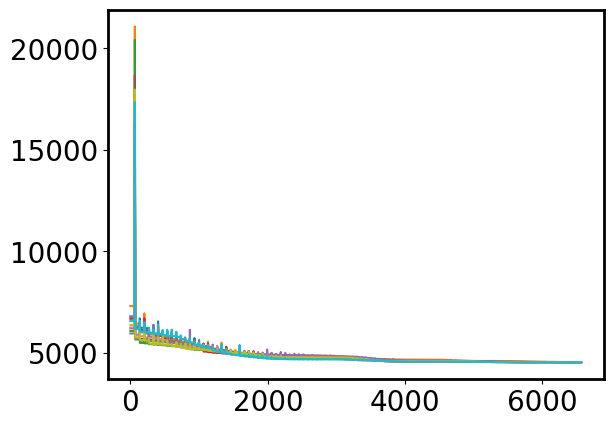

In [7]:
from scipy.optimize import minimize

def log_likelihood(params, win_matrix_serve, win_matrix_return, lose_matrix_serve, lose_matrix_return, n):
    gamma = params[:n]
    theta = params[n:]
    global history
    likelihood = 0
    for i in range(len(gamma)):
        for j in range(len(gamma)):
            a = win_matrix_serve[i, j]
            b = lose_matrix_serve[i, j]
            # likelihood += a * (np.log(theta * gamma[i] / (theta * gamma[i] + gamma[j]))) + b * (np.log(gamma[j] / (theta * gamma[i] + gamma[j])))
            likelihood += a * (np.log(theta[i] * gamma[i] / (theta[i] * gamma[i] + 1/theta[j] * gamma[j]))) + b * (np.log(1/theta[j] * gamma[j] / (theta[i] * gamma[i] + 1/theta[j] * gamma[j])))
    history.append(-likelihood)
    return -likelihood

def Bradley_Terry(win_matrix_serve, win_matrix_return, lose_matrix_serve, lose_matrix_return, seed=0):
    # 初始化参数, (0, 1) 之间
    n = len(player)
    gamma_theta = np.random.RandomState(seed).uniform(1, 1000, 2 * n)
    gamma_theta[n:] = np.random.RandomState(seed).uniform(0.5, 2, n)
    # gamma_theta[:-1] = -np.log(gamma_theta[:-1])
    # 优化, gamma_theta 位于 (0, 1) 之间
    constraints = ({'type': 'ineq', 'fun': lambda x: x - 1})
    result = minimize(log_likelihood, gamma_theta, args=(win_matrix_serve, win_matrix_return, lose_matrix_serve, lose_matrix_return, n), constraints=constraints)
    gamma = result.x[:n]
    theta = result.x[n:]
    cross_entropy = result.fun
    return gamma, theta, cross_entropy

gamma_list = []
theta_list = []
history_list = []
for seed in range(10):
    history = []
    gamma_serve, theta_serve, cross_entropy = Bradley_Terry(win_matrix_serve, win_matrix_return, lose_matrix_serve, lose_matrix_return, seed)
    plt.plot(history, label=f'seed={seed}')
    gamma_serve = gamma_serve / np.sum(gamma_serve)
    gamma_list.append(gamma_serve)
    theta_list.append(theta_serve)
    history_list.append(history)
    


In [8]:
# save
import os
save_root = r'C:\Users\cheng\Desktop\20240201\sourece\with_serve_v2'
os.makedirs(save_root, exist_ok=True)
np.save(save_root + r'\gamma_list.npy', gamma_list)
np.save(save_root + r'\theta_list.npy', theta_list)
np.save(save_root + r'\history_list.npy', np.array(history_list, dtype=object))

In [9]:
gamma_list = np.load(save_root + r'\gamma_list.npy')
theta_list = np.load(save_root + r'\theta_list.npy')
history_list = np.load(save_root + r'\history_list.npy', allow_pickle=True)

In [10]:
def abbreviate_name(full_name):
    """
    Converts a full name into abbreviated format suitable for academic papers.
    Args:
    - full_name (str): The full name to be abbreviated.
    
    Returns:
    - str: The abbreviated name.
    """
    parts = full_name.strip().split()
    if len(parts) == 1:  # Only last name provided
        return full_name
    else:
        # Abbreviate first and middle names, keep the last name as is
        abbreviated_parts = [f"{part[0]}." for part in parts[:-1]]
        abbreviated_name = " ".join(abbreviated_parts) + " " + parts[-1]
        return abbreviated_name

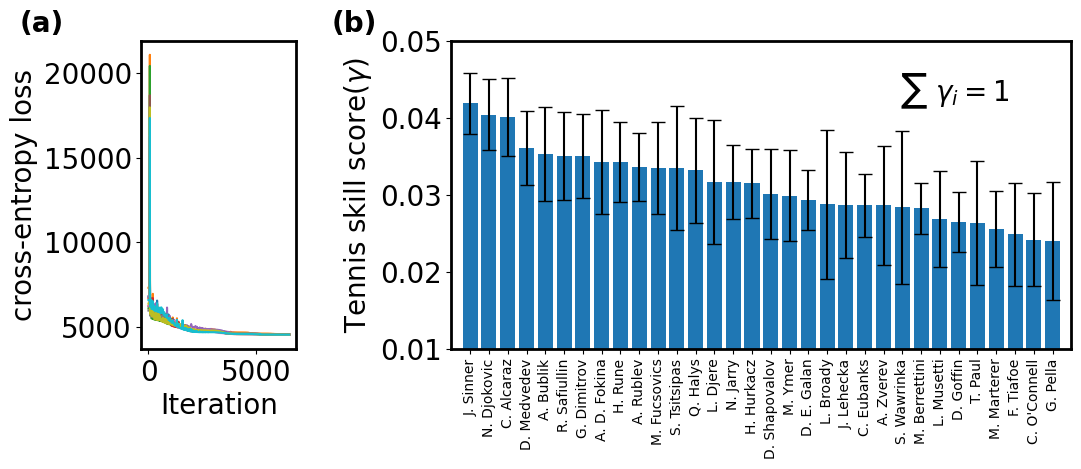

In [11]:

fondsize = 20
fig, axes = plt.subplots(1, 2, figsize=(12, 4), width_ratios=(1, 4))
# 两个子图间加间距
plt.subplots_adjust(wspace=0.4)
# 人名缩写
abbreviation = [abbreviate_name(name) for name in player]
gamma_list = np.array(gamma_list)
# mean, std
gamma_mean = np.mean(gamma_list, axis=0)
gamma_std = np.std(gamma_list, axis=0)

descend_index = np.argsort(-gamma_mean)
gamma_mean = gamma_mean[descend_index]
gamma_std = gamma_std[descend_index]
axes[0].text(-0.5, 1.1, '(a)', transform=axes[0].transAxes, fontsize=fondsize, weight='bold', va='top', ha='right')

abbreviation = [abbreviation[i] for i in descend_index]
for history_one_seed in history_list:
    axes[0].plot(history_one_seed)
axes[0].set_xlabel('Iteration', fontsize=fondsize)
axes[0].set_ylabel('cross-entropy loss', fontsize=fondsize)

# ,增加柱子之间的间距
axes[1].bar(np.arange(len(abbreviation)), gamma_mean, yerr=gamma_std, capsize=5)
axes[1].set_xticks(np.arange(len(player)))
# 调整字体大小
axes[1].set_xticklabels(abbreviation, rotation=90, fontsize=10)
axes[1].set_ylim(0.01, 0.05)
axes[1].set_xlim(-1, len(abbreviation))
# axes[1].set_xlabel('player')
axes[1].set_ylabel('Tennis skill score($\gamma$)', fontsize=fondsize)
axes[1].text(-0.12, 1.1, '(b)', transform=axes[1].transAxes, fontsize=fondsize, weight='bold', va='top', ha='right')
# axes[1].legend()
# 右上角加text \sum gaamma = 1
axes[1].text(0.9, 0.9, r'$\sum\ \gamma_i = 1$', transform=axes[1].transAxes, fontsize=fondsize, va='top', ha='right')
# xlabel 上加不同颜色的阴影


plt.show()

In [12]:
for history_one_seed in history_list:
    print(history_one_seed[-1])

4540.383699874378
4555.903853105242
4534.058469776331
4539.222826247993
4553.18643868836
4554.259847296692
4535.069335235666
4552.832956767415
4543.584080620837
4541.3712419430985
